<a href="https://colab.research.google.com/github/monicasoberon/recommendation/blob/main/Recommendation_Systems_Learner_Notebook_Full_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project: Amazon Product Recommendation System**

# **Marks: 60**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Installing surprise library**

In [ ]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 2.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357276 sha256=ccc9246f82e594eb7c095e5d36ed81f8bf9fbc5ada805d565b6c8b6c49deb2cb
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


## **Importing the necessary libraries and overview of the dataset**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from surprise.prediction_algorithms.matrix_factorization import SVD
from collections import defaultdict
from surprise.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [ ]:
dataset = pd.read_csv('/content/ratings_Electronics.csv', header=None)

In [ ]:
dataset.head()

,0,1,2,3
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [ ]:
dataset.shape

(7824482, 4)

Convert to dataframe before adding column names so first row isn't overwritten.

In [ ]:
dataset.columns = ['user_id', 'prod_id', 'rating', 'timestamp']

In [ ]:
df = dataset.drop('timestamp', axis=1)

In [ ]:
df.head()

,user_id,prod_id,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [128]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [129]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [130]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [131]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [132]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [133]:
df_final.shape

(65290, 3)

**Write your observations here: the dataframe now has 65290 columns, which unlike the dataset with 7,824,482 columns we had before, makes our model computationally possible. Also, it now has 3 columns instead of 4, because we dropped the timestamps column, which isn't relevant to the analysis we will be conducting.**

### **Data types**

In [ ]:
df_final.dtypes

,0
user_id,object
prod_id,object
rating,float64


**Observations: the user_id and prod_id are objects, this is because they have both letters and numbers, the rating is a float, this is means it is a number with decimals.**

### **Checking for missing values**

In [ ]:
# Checking for missing values in each column
missing_values = df_final.isnull().sum()

print(missing_values)

user_id    0
prod_id    0
rating     0
dtype: int64


**Observations: None of the columns have missing values.**

### **Summary Statistics**

In [ ]:
df_final['rating'].describe()

,rating
count,65290.000000
mean,4.294808
std,0.988915
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


**Observations: There are 65290 ratings, they vary from 1-5, The mean is 4.30 and the standard deviation is 0.99.**

### **Checking the rating distribution**

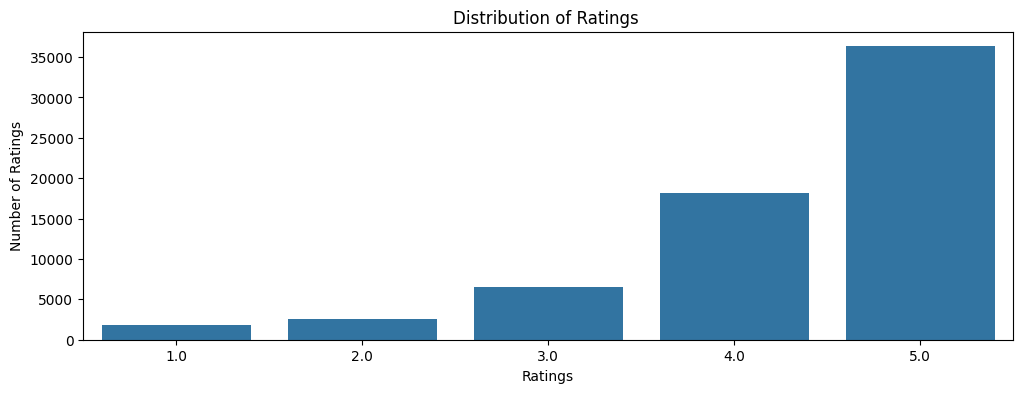

In [ ]:
plt.figure(figsize = (12, 4))
sns.countplot(x="rating", data=df_final)
plt.title("Distribution of Ratings ")
plt.xlabel("Ratings")
plt.ylabel("Number of Ratings")
plt.show()

**Observations: The ratings are heavily skewed to the left. Most products receive a rating of 5, making up more than 35000 of the 65290 total ratings. The second most given rating is 4, with around 20000 values. Few products received ratings of 1, 2 or 3.**

### **Checking the number of unique users and items in the dataset**

In [ ]:
print("total rows:", df_final.shape[0])
print("number of unique users:", df_final['user_id'].nunique())
print("number of unique products:",df_final['prod_id'].nunique())

total rows: 65290
number of unique users: 1540
number of unique products: 5689


**Observations: There are 5689 products in the dataset and 1540 unique users. Due to the number of users amd products there is a possibility of 5689 * 1540 = 8761060 ratings in the dataset. However, we only have 65290 ratings, which means not every user has rated every product, permitting us to create a recommendation system to help users find the products they are most likely to be interested in or buy.**

### **Users with the most number of ratings**

In [ ]:
df_final['user_id'].value_counts().head(10)

,count
user_id,
ADLVFFE4VBT8,295
A3OXHLG6DIBRW8,230
A1ODOGXEYECQQ8,217
A36K2N527TXXJN,212
A25C2M3QF9G7OQ,203
A680RUE1FDO8B,196
A1UQBFCERIP7VJ,193
A22CW0ZHY3NJH8,193
AWPODHOB4GFWL,184


**Observations: The user with the most ratings is user A231WM2Z2JL0U3 with 295 ratings of products. The user still has the possibility to interact with 5689-295 = 5394 of the products in the dataset.**

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [ ]:
# Calculate the average rating for each product
average_rating = df_final.groupby('prod_id')['rating'].mean()

# Calculate the count of ratings for each product
rating_count = df_final.groupby('prod_id')['rating'].count()

# Create a dataframe with calculated average and count of ratings
rating_df = pd.DataFrame({'avg_rating': average_rating, 'rating_count': rating_count})

# Sort the dataframe by average of ratings in the descending order
rating_df.sort_values('avg_rating', ascending = False, inplace = True)

# See the first five records of the "final_rating" dataset
rating_df.head()

,avg_rating,rating_count
prod_id,,
B00LGQ6HL8,5.0,5
B003DZJQQI,5.0,14
B005FDXF2C,5.0,7
B00I6CVPVC,5.0,7
B00B9KOCYA,5.0,8


In [ ]:
def get_top_products(rating_df, min_interactions, top_n):
    # Filter products that have at least the minimum number of interactions (ratings)
    recommendation = rating_df[rating_df['rating_count'] >= min_interactions]

    # Sort by average rating in descending order
    recommendation = recommendation.sort_values(by='avg_rating', ascending=False)

    # Return the top n products
    return recommendation.head(top_n)

### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [ ]:
get_top_products(rating_df, 50, 5)

,avg_rating,rating_count
prod_id,,
B001TH7GUU,4.871795,78
B003ES5ZUU,4.864130,184
B0019EHU8G,4.855556,90
B006W8U2MU,4.824561,57
B000QUUFRW,4.809524,84


### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [ ]:
get_top_products(rating_df, 100, 5)

,avg_rating,rating_count
prod_id,,
B003ES5ZUU,4.864130,184
B000N99BBC,4.772455,167
B002WE6D44,4.770000,100
B007WTAJTO,4.701220,164
B002V88HFE,4.698113,106


We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [ ]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [ ]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [111]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(1,5))

# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size = 0.3, random_state = 42)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [ ]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': True}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
knn_user = KNNBasic(sim_options=sim_options, verbose = False, random_state = 1)

# Fit the model on the training data
knn_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(knn_user)

RMSE: 1.0250
Precision:  0.86
Recall:  0.783
F_1 score:  0.82


**Observations: The baseline model has a root mean square error of 1.03 on the test set. Precision represents the fraction of recommended items that are actually relevant, with this model 86% of recommended items are relevant. Recall represent the fraction of actually relevant items that are recommended to the user, of actually relevant items, 78% are recommended to the user. The F1 score is the harmonic mean of Precision and Recall, in this case 0.82. This indicates most recommended items were relevant and most relevant items were recommended. Tuning the hyperparameters of the algorithm can help us raise the F1 score.**

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [ ]:
# Predicting rating for a sample user with an interacted product
knn_user.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.00   {'actual_k': 4, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.0, details={'actual_k': 4, 'was_impossible': False})

**Observations: The estimated rating for item: 1400501466 by user: A3LDPF5FMB782Z was 3.0, however, the rating given was 5.0. The estimated value was not accurate. The prediction is possible due to the fact that both the user and item exist in the dataset. The actual_k refers to the number of neighbors used.**

Below is the function to find the **list of users who have not seen the product with product id "1400501466"**.

In [ ]:
def n_users_not_interacted_with(n, data, prod_id):
    users_interacted_with_product = set(data[data['prod_id'] == prod_id]['user_id'])
    all_users = set(data['user_id'])
    return list(all_users.difference(users_interacted_with_product))[:n] # where n is the number of elements to get in the list

In [113]:
# Find unique user_id where prod_id is not equal to "1400501466"
n_users_not_interacted_with(5, df_final, '1400501466')

['A2HDTOF8222KN3',
 'A2W0XCWOK3MW6F',
 'A1522TN5FVJL0Y',
 'A1VOFY3QFT9WCG',
 'AIFLY2HF8NS8U']

* It can be observed from the above list that **user "A2UOHALGF2X77Q" has not seen the product with productId "1400501466"** as this user id is a part of the above list.

**Below we are predicting rating for `userId=A2UOHALGF2X77Q` and `prod_id=1400501466`.**

In [114]:
# Predicting rating for a sample user with a non interacted product
knn_user.predict('A2UOHALGF2X77Q', '1400501466', verbose=True)

user: A2UOHALGF2X77Q item: 1400501466 r_ui = None   est = 5.00   {'actual_k': 1, 'was_impossible': False}


Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=5, details={'actual_k': 1, 'was_impossible': False})

**Observations: The estimated rating for item: 1400501466 by user: A2UOHALGF2X77Q was 5.0, however, since the user has not interacted or seen the product we do not have the real rating. The actual_k is 1, so the prediction was made using one neighbor.**

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [115]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
    'k': [20, 30, 40],
    'min_k': [1, 3, 6],
    'sim_options': {'name': ['msd', 'cosine', 'pearson', 'pearson_baseline'],
                    'user_based': [True]}
}

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print("best score:", gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print("best parameters", gs.best_params)

best score: 0.9715009970455392
best parameters {'rmse': {'k': 40, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [ ]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based': True}
# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_optimized = KNNBasic(sim_options = sim_options, k = 40, min_k = 6)

# Training the algorithm on the trainset
sim_user_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(sim_user_optimized)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9630
Precision:  0.85
Recall:  0.809
F_1 score:  0.829


**Observations: After using gridSearchCV, the optimal value for the parameters was discovered and put into practice. Utilizing the optimal parameters, the root mean square error dropped from 1.0250 to 0.963. Additionally, the model's F1 score rose from 0.82 to 0.829.**

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A2UOHALGF2X77Q"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [119]:
filtered_df = df_final[(df_final['prod_id'] == '1400501466') & (df_final['user_id'] == 'A3LDPF5FMB782Z')]

# Display the filtered rows
print(filtered_df)

             user_id     prod_id  rating
1310  A3LDPF5FMB782Z  1400501466     5.0


In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
sim_user_optimized.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5,verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.291403190162572, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [ ]:
knn_user.predict('A3LDPF5FMB782Z', '1400501466',  r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.00   {'actual_k': 4, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.0, details={'actual_k': 4, 'was_impossible': False})

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A2UOHALGF2X77Q" and productId "1400501466"
sim_user_optimized.predict('A2UOHALGF2X77Q', '1400501466', verbose=True)

user: A2UOHALGF2X77Q item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=4.291403190162572, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [ ]:
knn_user.predict('A2UOHALGF2X77Q', '1400501466', verbose=True)

user: A2UOHALGF2X77Q item: 1400501466 r_ui = None   est = 5.00   {'actual_k': 1, 'was_impossible': False}


Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=5, details={'actual_k': 1, 'was_impossible': False})

**Observations: Both predictions were impossible with the new model due to the fact that there were not enough neighbors in either of them to use sim_user_optimized, which only works with at least 6 neighbors. In the first prediction sim_user_optimized predicted an estimate of 4.29, closer to the actual rating of 5 but flagged as unreliable due to insufficient neighbors. Knn_user predicted 3.0, which is farther but used 4 neighbors. In the second prediction sim_user_optimized predicted 4.29, while knn_user predicter 5.0.**

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [ ]:
# 0 is the inner id of the above user
sim_user_optimized.get_neighbors(0, k = 5)


[7, 12, 16, 17, 26]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [ ]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [120]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
get_recommendations(df_final, 'A3LDPF5FMB782Z', 5, sim_user_optimized)

[('B002WE6D44', 5),
 ('B00834SJSK', 5),
 ('B00006RVPW', 4.999999999999999),
 ('B002V8C3W2', 4.888434908534113),
 ('B007WTAJTO', 4.88231059884685)]

In [121]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
df_recommendations = pd.DataFrame(get_recommendations(df_final, 'A3LDPF5FMB782Z', 5, sim_user_optimized), columns = ['prod_id', 'predicted_ratings'])
df_recommendations

,prod_id,predicted_ratings
0,B002WE6D44,5.000000
1,B00834SJSK,5.000000
2,B00006RVPW,5.000000
3,B002V8C3W2,4.888435
4,B007WTAJTO,4.882311


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [ ]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': False}

# KNN algorithm is used to find desired similar items. Use random_state=1
knn_item = KNNBasic(sim_options = sim_options, random_state = 1)

# Train the algorithm on the trainset, and predict ratings for the test set
knn_item.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(knn_item)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0232
Precision:  0.835
Recall:  0.758
F_1 score:  0.795


**Observations: The RMSE is of 1.023, lower than the original user-user model but a bit higher than the optimized user-user model. The F1 Score on the test set is of 0.795. We will try to improve these stats by using GridSearchCV, like in the user-user algorithm.**

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [ ]:
# Predicting rating for a sample user with an interacted product
knn_item.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)


user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.32   {'actual_k': 19, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.315789473684211, details={'actual_k': 19, 'was_impossible': False})

**Observations: The estimated rating for item 1400501466 by user A2UOHALGF2X77Q was 4.32, however the real rating was 5.0. The prediction was made using 19 neighbors (actual_k = 19), which indicates that the estimate is fairly robust.**

Below we are **predicting rating for the `userId = A2UOHALGF2X77Q` and `prod_id = 1400501466`**.

In [ ]:
# Predicting rating for a sample user with a non interacted product
knn_item.predict('A2UOHALGF2X77Q', '1400501466', verbose=True)

user: A2UOHALGF2X77Q item: 1400501466 r_ui = None   est = 4.00   {'actual_k': 1, 'was_impossible': False}


Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=4.0, details={'actual_k': 1, 'was_impossible': False})

**Observations: User A2UOHALGF2X77Q hasn't interacted with item: 1400501466 yet. However the knn item-item model predicted a rating of 4.0 based on one neighbor.**

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [109]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
    'k': [10, 20, 30],
    'min_k': [3, 6, 9],
    'sim_options': {'name': ['msd', 'cosine'],
                    'user_based': [False]}
}

# Performing 3-fold cross validation to tune the hyperparameters
grid = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the data
grid.fit(data)

# Find the best RMSE score
print("best score:", grid.best_score['rmse'])

# Find the combination of parameters that gave the best RMSE score
print("best parameters", grid.best_params)

best score: 0.9752197671218158
best parameters {'rmse': {'k': 20, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [123]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'msd',
               'user_based': False}
# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(sim_options = sim_options, k = 20, min_k = 6)
# Training the algorithm on the trainset
sim_item_item_optimized.fit(trainset)

# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(sim_item_item_optimized)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9694
Precision:  0.836
Recall:  0.797
F_1 score:  0.816


**Observations: Using GridSearchCV helped build an optimized item-item similarity model. This new model has a RMSE of 0.9694 compared to 1.0232 found in the old model. Also, the F1 score rose from 0.795 to 0.816. Hyperparameter tuing made the model better.**

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A2UOHALGF2X77Q"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [134]:
print(df_final[(df_final['prod_id'] == '1400501466') & (df_final['user_id'] == 'A3LDPF5FMB782Z')])

             user_id     prod_id  rating
1310  A3LDPF5FMB782Z  1400501466     5.0


In [135]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
sim_item_item_optimized.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.70   {'actual_k': 19, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.699444206926037, details={'actual_k': 19, 'was_impossible': False})

In [125]:
# Use sim_item_item_optimized model to recommend for userId "A2UOHALGF2X77Q" and productId "1400501466"
sim_item_item_optimized.predict('A2UOHALGF2X77Q', '1400501466', verbose=True)

user: A2UOHALGF2X77Q item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=4.291403190162572, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**The model performed well for the first user (A3LDPF5FMB782Z), providing a prediction (4.7) close to the actual rating (5.0) with 19 neighbors. For the second user (A2UOHALGF2X77Q), the model struggled due to insufficient neighbors, resulting in an unreliable estimate.**

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [136]:
sim_item_item_optimized.get_neighbors(0, k = 5)

[53, 67, 106, 151, 156]

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [141]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
get_recommendations(df_final, 'A1A5KUIIIHFF4U', 5, sim_item_item_optimized)

[('1400532655', 4.291403190162572),
 ('1400599997', 4.291403190162572),
 ('9983891212', 4.291403190162572),
 ('B00000DM9W', 4.291403190162572),
 ('B00000J1V5', 4.291403190162572)]

In [144]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
recommendations_item_df = pd.DataFrame(get_recommendations(df_final, 'A1A5KUIIIHFF4U', 5, sim_item_item_optimized), columns = ['prod_id', 'predicted_ratings'])
print(recommendations_item_df)

      prod_id  predicted_ratings
0  1400532655           4.291403
1  1400599997           4.291403
2  9983891212           4.291403
3  B00000DM9W           4.291403
4  B00000J1V5           4.291403


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [145]:
# Using SVD matrix factorization. Use random_state = 1
svd = SVD(random_state = 1)

# Training the algorithm on the trainset
svd.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd)


RMSE: 0.8989
Precision:  0.86
Recall:  0.797
F_1 score:  0.827


**Write your observations here: The RMSE (0.9) is lower than the user-user, normal (1.025) and optimized (0.963) recommendation systems, as well as the item-item normal (1.023) and optimized (0.969) recommendation systems. Additionally, the F_1 score (0.827) is higher than in the normal user-user (0.82), item-item normal (0.795) and optimized (0.816) recommendation systems. The only system with a higher F_1 score is the user-user optimized system with a score of 0.829, with a small difference of 0.002.**

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [146]:
print(df_final[(df_final['prod_id'] == '1400501466') & (df_final['user_id'] == 'A3LDPF5FMB782Z')])

             user_id     prod_id  rating
1310  A3LDPF5FMB782Z  1400501466     5.0


In [147]:
# Making prediction
svd.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.07   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.070652912318144, details={'was_impossible': False})

**Observations: The estimated rating with the model of 4.07 was fairly similar to the real rating, of 5.0.**

**Below we are predicting rating for the `userId = "A2UOHALGF2X77Q"` and `productId = "1400501466"`.**

In [148]:
print(df_final[(df_final['prod_id'] == '1400501466') & (df_final['user_id'] == 'A2UOHALGF2X77Q')])

Empty DataFrame
Columns: [user_id, prod_id, rating]
Index: []


In [149]:
# Making prediction
svd.predict('A2UOHALGF2X77Q', '1400501466', verbose=True)

user: A2UOHALGF2X77Q item: 1400501466 r_ui = None   est = 4.04   {'was_impossible': False}


Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=4.044492866803394, details={'was_impossible': False})

**Observations: The model predicted a rating of 4.04 for userId = "A2UOHALGF2X77Q" and productId = "1400501466", however since the user hasn't interacted with this specific product we do not know we do not know the actual rating.**

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [150]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross-validation
gs_cv = GridSearchCV(SVD, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting data
gs_cv.fit(data)

# Best RMSE score
print("Best RMSE score: ", gs_cv.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print("Best parameters: ", gs_cv.best_params)

Best RMSE score:  0.8975914030596385
Best parameters:  {'rmse': {'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [160]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
svd_algo_optimized = SVD(n_epochs = 20, lr_all = 0.01, reg_all = 0.2, random_state = 1)

# Train the algorithm on the trainset
svd_algo_optimized.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_algo_optimized)

RMSE: 0.8899
Precision:  0.862
Recall:  0.796
F_1 score:  0.828


**Observations: The optimized model has a lower RMSE and a slightly higher F_1 score than the previous model.**

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A2UOHALGF2X77Q"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [170]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
print(df_final[(df_final['prod_id'] == '1400501466') & (df_final['user_id'] == 'A3LDPF5FMB782Z')])
print()
print("Prediction with optimized svd model:")
print(svd_algo_optimized.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True))
print()
print("Prediction with normal svd model:")
print(svd.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True))
print()
print("Recommendations:")
get_recommendations(df_final, "A3LDPF5FMB782Z", 5, svd_algo_optimized)

             user_id     prod_id  rating
1310  A3LDPF5FMB782Z  1400501466     5.0

Prediction with optimized svd model:
user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.12   {'was_impossible': False}
user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.12   {'was_impossible': False}

Prediction with normal svd model:
user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.07   {'was_impossible': False}
user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.07   {'was_impossible': False}

Recommendations:


[('B00006HSYC', 4.920761530142896),
 ('B00104XCVO', 4.880277042920078),
 ('B000053HC5', 4.864472906535294),
 ('B0010Z28XG', 4.860567539420121),
 ('B00BQ4F9ZA', 4.854917103138285)]

In [174]:
# Use svd_algo_optimized model to recommend for userId "A2UOHALGF2X77Q" and productId "1400501466"
print("Prediction with optimized svd model:")
print(svd_algo_optimized.predict('A2UOHALGF2X77Q', '1400501466', verbose=True))
print()
print("Prediction with normal svd model:")
print(svd.predict('A2UOHALGF2X77Q', '1400501466', verbose=True))
print()
print("Recommendations:")
get_recommendations(df_final, "A2UOHALGF2X77Q", 5, svd_algo_optimized)

Prediction with optimized svd model:
user: A2UOHALGF2X77Q item: 1400501466 r_ui = None   est = 3.99   {'was_impossible': False}
user: A2UOHALGF2X77Q item: 1400501466 r_ui = None   est = 3.99   {'was_impossible': False}

Prediction with normal svd model:
user: A2UOHALGF2X77Q item: 1400501466 r_ui = None   est = 4.04   {'was_impossible': False}
user: A2UOHALGF2X77Q item: 1400501466 r_ui = None   est = 4.04   {'was_impossible': False}

Recommendations:


[('B00BQ4F9ZA', 4.939705377356294),
 ('B001QUA6RA', 4.915091504230455),
 ('B00AR95ESC', 4.893015493422161),
 ('B000FQ2JLW', 4.891861095750733),
 ('B0033PRWSW', 4.883665126647126)]

### **Conclusion and Recommendations**

**Write your conclusion and recommendations here**